In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [21]:
# --- Считывание данных ---
price_df = pd.read_csv("../data/prices/BTC_100ms.csv")         # timestamp, price
adc_df = pd.read_csv("../data/adc/BTC_100ms_w100.csv")             # timestamp, adc
ind_df = pd.read_csv("../data/indicators/BTC_100ms.csv")      # timestamp, rsi, macd, bb_width, volatility, etc.

# --- Слияние по timestamp ---
df = pd.concat([price_df, adc_df, ind_df], axis=1)
df = df.dropna()

# --- Подготовка ---
feature_cols = [c for c in df.columns if c not in ["timestamp", "adc"]]
target_col = "adc"
horizon = 10
window_size = 30

# стандартизация фичей
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# --- Подготовка данных для LSTM ---
def prepare_lstm_data(df, feature_cols, target_col, window_size=30, horizon=10):
    X, y = [], []
    data = df[feature_cols + [target_col]].values
    for i in range(window_size, len(data) - horizon):
        X.append(data[i - window_size:i, :-1])
        y.append(data[i + horizon, -1])
    return np.array(X), np.array(y)

X, y = prepare_lstm_data(df, feature_cols, target_col, window_size, horizon)

# --- Трейн/тест ---
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [22]:
# --- Модель ---
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])
model.compile(optimizer=Adam(0.001), loss="mse")
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - loss: 3.8800e-04 - val_loss: 4.6221e-05
Epoch 2/20
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 62s 7ms/step - loss: 7.8541e-05 - val_loss: 4.4177e-05
Epoch 3/20
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 62s 7ms/step - loss: 7.3061e-05 - val_loss: 4.3351e-05
Epoch 4/20
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 7.1677e-05 - val_loss: 4.2240e-05
Epoch 5/20
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 61s 7ms/step - loss: 7.1555e-05 - val_loss: 4.2005e-05
Epoch 6/20
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 63s 7ms/step - loss: 7.0773e-05 - val_loss: 4.2533e-05
Epoch 7/20
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 7.0875e-05 - val_loss: 4.2612e-05
Epoch 8/20
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - loss: 7.0840e-05 - val_loss: 4.2390e-05
Epoch 9/20
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 7.0931e-05 - val_loss: 4.2373e-05
Epoch 10/20
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 61s 7ms/step - loss: 7.0787e-05 - val_loss: 4.2467e-05
Epoch 11/20
8808/8808 ━━━━━━━

In [25]:
# --- Оценка ---
y_pred = model.predict(X_test).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
sign_acc = accuracy_score(y_test > 0, y_pred > 0)

print(f"RMSE: {rmse:.4f}")
print(f"Sign Accuracy: {sign_acc:.4f}")

5505/5505 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
RMSE: 0.0097
Sign Accuracy: 0.6922


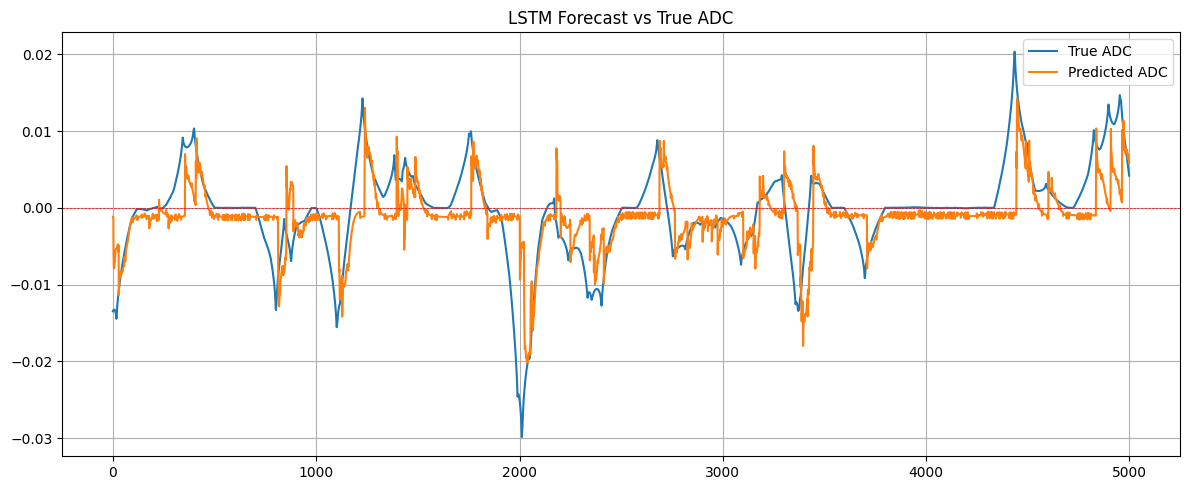

In [27]:
# --- Визуализация ---
plt.figure(figsize=(12, 5))
plt.plot(y_test[:5000], label="True ADC")
plt.plot(y_pred[:5000], label="Predicted ADC")
plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
plt.title("LSTM Forecast vs True ADC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
model.save("../models/lstm_BTC_100ms_w100.keras")